# **Good Cop, Bad Cop**

An analysis of the demographics of US Police Shooting victims.

By: Cassidy Frier, Aditi Panchal, Olivia Ornelas, Addie Relampagos

# Overview and Motivation

We believe that the rate at how police killings and violence in the US have become increasingly common is disturbing and want to know **whether certain demographics really make a difference on whether or not someone will experience police violence**. We plan on exploring this pattern by analyzing police stops and use of force data in Minneapolis, as well as police killings nationwide. 

Goal:  We hope to find some insight to this question based on several factors from a purely scientific background. Gaining more of an idea of the factors that contribute most to someone's likelihood of experiencing violence by police, could be helpful to help mitigate this problem in the future. We specifically chose datasets found on Kaggle, to be able to actually contribute our insights to the data science community focused on reducing police brutality rates.

# Related Works

- The issue of police brutality coming to light specifically in Minneapolis due to the murder of George Floyd

- The Kaggle datasets we used can be found here:
  - [Minneapolis Police Stops and Police Violence](https://www.kaggle.com/paultimothymooney/minneapolis-police-stops-and-police-violence?select=police_stop_data.csv) (originally from Open Data Minneapolis)
  - [US Police Killings](https://www.kaggle.com/ahsen1330/us-police-shootings) 



# Initial Questions

Our initial question was: "Can certain demographics effect someone's chance of experiencing police violence?" After getting feedback from peers and cleaning our data, this question evolved to look at how many encounters actually became violent and how are levels of violence evolving based on age (police use of force for people over 50 vs. people under 30). <b>New questions that were considered throughout the analysis</b>: "How does the levels of force vary by race?" "How effective are certain types of force used?"

# Data

`First, we read in the police stop and police violence data to be able to combine them, to be able to assess what groups are more likely to be stopped, as compared to what groups are exposed to violence the most.`

In [ ]:
#adding imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
!python -m pip install dask[dataframe] --upgrade
import dask.dataframe as dd
from matplotlib import cm
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
#!pip install wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn import tree
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
import math
import numpy as np


Requirement already up-to-date: dask[dataframe] in /usr/local/lib/python3.6/dist-packages (2.30.0)
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
pol_stop = pd.read_csv('police_stop_data.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


`We then cleaned the data (removing columns we don't need, dropping rows with blanks, etc) `

In [ ]:
pol_stop = pol_stop.drop(columns=['OBJECTID', 'masterIncidentNumber', 'reason', 'callDisposition', 'citationIssued', 'preRace', 'lat', 'long', 'x', 'y', 'lastUpdateDate'])
pol_stop.dropna()

,responseDate,problem,personSearch,vehicleSearch,race,gender,policePrecinct,neighborhood
0,2016/10/31 22:40:47+00,Suspicious Person (P),YES,NO,Black,Male,1.0,Downtown West
1,2016/10/31 23:06:36+00,Traffic Law Enforcement (P),NO,NO,Black,Male,5.0,Steven's Square - Loring Heights
2,2016/10/31 23:20:54+00,Attempt Pick-Up (P),NO,NO,Unknown,Unknown,4.0,Webber - Camden
3,2016/10/31 23:23:20+00,Suspicious Person (P),YES,NO,Black,Male,3.0,Corcoran
4,2016/10/31 23:26:05+00,Suspicious Vehicle (P),NO,NO,Unknown,Male,3.0,Hale
...,...,...,...,...,...,...,...,...
168318,2020/10/29 02:04:42+00,Suspicious Vehicle (P),NO,NO,Unknown,Unknown,1.0,Downtown West
168319,2020/10/29 02:33:18+00,Suspicious Person (P),NO,NO,Unknown,Male,1.0,Downtown East
168320,2020/10/29 03:25:32+00,Suspicious Vehicle (P),NO,NO,Unknown,Unknown,4.0,Harrison
168321,2020/10/29 04:43:36+00,Suspicious Person (P),NO,NO,Black,Male,1.0,Downtown East


In [ ]:
pol_force = pd.read_csv('police_use_of_force.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (5,6,7,8,10,12,13,14,15,17,18) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
pol_force = pol_force.drop(columns=['X', 'Y', 'PoliceUseOfForceID', 'CaseNumber', 'Is911Call', 'ForceReportNumber', 'SubjectRole', 'SubjectRoleNumber', 'TotalCityCallsForYear', 'TotalPrecinctCallsForYear', 'TotalNeighborhoodCallsForYear', 'CenterGBSID', 'CenterLatitude', 'CenterLongitude', 'CenterX', 'CenterY', 'DateAdded', 'OBJECTID'])
pol_force = pol_force.rename(columns={'ResponseDate': 'responseDate', 'Problem': 'problem', 'Race': 'race', 'Sex': 'gender', 'Precinct': 'policePrecinct', 'Neighborhood': 'neighborhood'})
pol_force = pol_force.dropna()

pol_force

,responseDate,problem,PrimaryOffense,SubjectInjury,ForceType,ForceTypeAction,race,gender,EventAge,TypeOfResistance,policePrecinct,neighborhood
0,2008/01/08 02:07:17+00,Unknown Trouble,DASLT5,No,Bodily Force,Punches,Black,Male,29.0,Tensed,04,Near - North
1,2008/01/13 02:21:55+00,Unknown Trouble,CBYMIN,No,Bodily Force,Slaps,White,Male,18.0,Tensed,05,Lowry Hill
2,2008/01/19 22:04:01+00,Suspected Hazard,ASLT5,Yes,Taser,Firing Darts,Black,Male,50.0,Assaulted Officer,01,Downtown West
3,2008/02/02 05:32:56+00,Domestic Abuse-In Progress,OBSTRU,Yes,Taser,Touch,White,Male,41.0,Commission of Crime,02,Windom Park
4,2008/02/09 00:31:01+00,Recover Vehicle,RECVEH,No,Taser,Firing Darts,Black,Male,16.0,Fled on Foot,04,Folwell
...,...,...,...,...,...,...,...,...,...,...,...,...
31925,2019/11/15 22:24:08+00,Check the Welfare,CIC,Yes,Bodily Force,Body Weight Pin,White,Female,27.0,Other ...,05,Whittier
31928,2020/01/06 07:33:06+00,Check the Welfare,CIC,No,Bodily Force,Kicks,Black,Female,27.0,Assaulted Officer ...,03,Corcoran
31933,2020/03/14 23:51:06+00,Disturbance,ASLT5,Yes,Maximal Restraint Technique,Side Recovery Position,Black,Male,24.0,Commission of a Crime ...,01,Downtown West
32030,2019/11/12 16:45:45+00,Assist Fire Personnel,DISARM,Yes,Bodily Force,Takedown,White,Male,43.0,Commission of a Crime ...,05,Whittier


`Here we combine the stops and violence data into one dataframe`

In [ ]:
df = pd.concat([pol_stop, pol_force], ignore_index=True)
df #NaN values show when there was no use of force involved

,responseDate,problem,personSearch,vehicleSearch,race,gender,policePrecinct,neighborhood,PrimaryOffense,SubjectInjury,ForceType,ForceTypeAction,EventAge,TypeOfResistance
0,2016/10/31 22:40:47+00,Suspicious Person (P),YES,NO,Black,Male,1,Downtown West,NaN,NaN,NaN,NaN,NaN,NaN
1,2016/10/31 23:06:36+00,Traffic Law Enforcement (P),NO,NO,Black,Male,5,Steven's Square - Loring Heights,NaN,NaN,NaN,NaN,NaN,NaN
2,2016/10/31 23:20:54+00,Attempt Pick-Up (P),NO,NO,Unknown,Unknown,4,Webber - Camden,NaN,NaN,NaN,NaN,NaN,NaN
3,2016/10/31 23:23:20+00,Suspicious Person (P),YES,NO,Black,Male,3,Corcoran,NaN,NaN,NaN,NaN,NaN,NaN
4,2016/10/31 23:26:05+00,Suspicious Vehicle (P),NO,NO,Unknown,Male,3,Hale,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187580,2019/11/15 22:24:08+00,Check the Welfare,NaN,NaN,White,Female,05,Whittier,CIC,Yes,Bodily Force,Body Weight Pin,27.0,Other ...
187581,2020/01/06 07:33:06+00,Check the Welfare,NaN,NaN,Black,Female,03,Corcoran,CIC,No,Bodily Force,Kicks,27.0,Assaulted Officer ...
187582,2020/03/14 23:51:06+00,Disturbance,NaN,NaN,Black,Male,01,Downtown West,ASLT5,Yes,Maximal Restraint Technique,Side Recovery Position,24.0,Commission of a Crime ...
187583,2019/11/12 16:45:45+00,Assist Fire Personnel,NaN,NaN,White,Male,05,Whittier,DISARM,Yes,Bodily Force,Takedown,43.0,Commission of a Crime ...


# Exploratory Data Analysis

`Since most of our data is categorical, we decided to start off by analyzing the US Police Killings dataset and generate a word cloud based on the races of people killed by police and the frequency of that race in the dataset.`

In [ ]:
pol_killings = pd.read_csv('PoliceKillingsUS.csv', encoding='cp1252')
pol_killings = pol_killings.drop(columns=['id', 'name', 'date'])
top10 = pol_killings['armed'].value_counts()[:7].index
pol_killings.loc[~pol_killings['armed'].isin(top10), 'armed'] = 'other'
pol_killings

,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera,arms_category
0,shot,gun,53.0,M,Asian,Shelton,WA,True,attack,Not fleeing,False,Guns
1,shot,gun,47.0,M,White,Aloha,OR,False,attack,Not fleeing,False,Guns
2,shot and Tasered,unarmed,23.0,M,Hispanic,Wichita,KS,False,other,Not fleeing,False,Unarmed
3,shot,toy weapon,32.0,M,White,San Francisco,CA,True,attack,Not fleeing,False,Other unusual objects
4,shot,other,39.0,M,Hispanic,Evans,CO,False,attack,Not fleeing,False,Piercing objects
...,...,...,...,...,...,...,...,...,...,...,...,...
4890,shot,other,27.0,M,Black,Atlanta,GA,False,attack,Foot,True,Electrical devices
4891,shot,gun,23.0,M,Black,Crown Point,IN,False,attack,Car,False,Guns
4892,shot,unarmed,25.0,F,White,Sedalia,MO,False,other,Not fleeing,False,Unarmed
4893,shot,gun,22.0,M,White,Kansas City,MO,False,other,Other,False,Guns


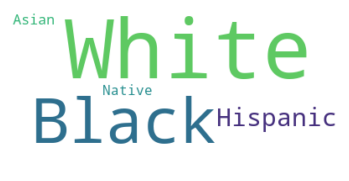

In [ ]:
stop_words = set(stopwords.words('english'))

raceText = " ".join(race.strip() for race in pol_killings.race if not pd.isnull(race))
#print(raceText)

wordcloud = WordCloud(stopwords=stop_words, background_color="white").generate(raceText)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

`We can see that the largest words are "White" and "Black," respectively. This, when taking into account the percentage of these races in the US population, is concerning, as Black people make a much smaller portion of the population but the word is significantly larger than other minority groups. `

`Next we look back to the Minneapolis dataset, since data for only killings does not give us a full picture of violence in police encounters. `

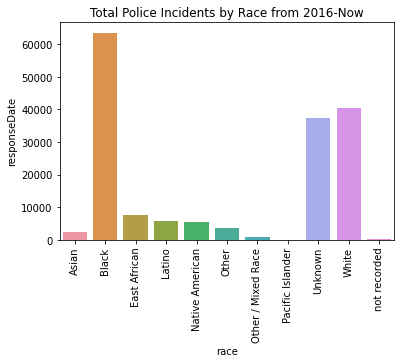

In [ ]:
# Initial Barplot of race
Race = df.groupby(['race']).count()
sns.barplot(x=Race.index,y=Race.responseDate)
plt.xticks(rotation='vertical')
plt.title('Total Police Incidents by Race from 2016-Now')
plt.show()

`This visual gives us an idea of the role that race may play in police encounters and the likelihood of an individual experience violence by police in Minneapolis. As a group, Black Americans seem to be disproportionately experiencing violence, confirming our initial beliefs and news about the role racism plays in policing. We can now further explore the various types of forces exerted and how it may differ between races.`

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


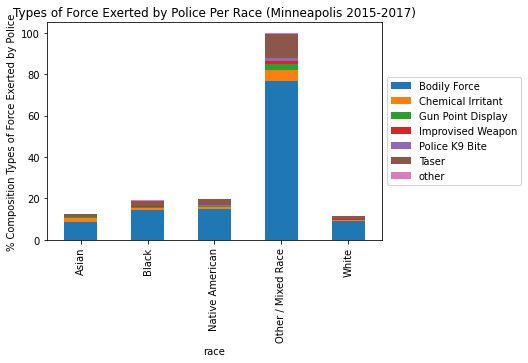

In [ ]:
df[['ForceType','PrimaryOffense','SubjectInjury','ForceTypeAction','EventAge','TypeOfResistance']] = df[['ForceType','PrimaryOffense','SubjectInjury','ForceTypeAction','EventAge','TypeOfResistance']].fillna('N/A',inplace=False) #Negative value to show how many didn't escalate
df['race'] = df['race'].fillna('unknown',inplace=False)
Popular_race = df[(df.race == "Black") | (df.race == "White") | (df.race == "Asian") | (df.race == "Native American") | (df.race == "Other / Mixed Race")]

top7forces1 = Popular_race['ForceType'].value_counts()[:7].index
Popular_race.loc[~Popular_race['ForceType'].isin(top7forces1), 'ForceType'] = 'other'
Force = ((Popular_race.groupby(['race','ForceType']).count() / Popular_race.groupby(['race']).count()) * 100)
Force[['Race','force']] = Force.index.to_frame() #How to get non applicable forceTypes..?
Force = Force[(Force.force != "N/A")]

# print(Force.head)
df3 = Force[['Race','force', 'responseDate']]
df3vals = Force['force'].unique()
# print(df3vals)

# sns.catplot(x='force', y='responseDate', hue='Race', data=Force,kind='swarm',palette=sns.color_palette('tab10',10)) #Change color for better visibility
#Stripplot is similar for a scatter plot (kind=swarm)
#but collapses overlapping points. {{Not sure which one to use}}

# plt.xticks(rotation='vertical')
# plt.title('Types of force by race')

g = df3.unstack().plot.bar(stacked=True)
g.legend(df3vals, loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Types of Force Exerted by Police Per Race (Minneapolis 2015-2017)")
plt.ylabel("% Composition Types of Force Exerted by Police")
#todo : sort levels of bar chart
plt.show()

`Here we can see the composition of the different types of force among each race that had force inflicted upon them; bodily force is most common among races, however Asian seems to have the highest percentage of being exposed to chemical irritants.`


`Since Black and White Americans have the highest percentage of police stops and violence inflicted upon them, we decided to analyze these races and the types of weapons used against them, in more detail.`

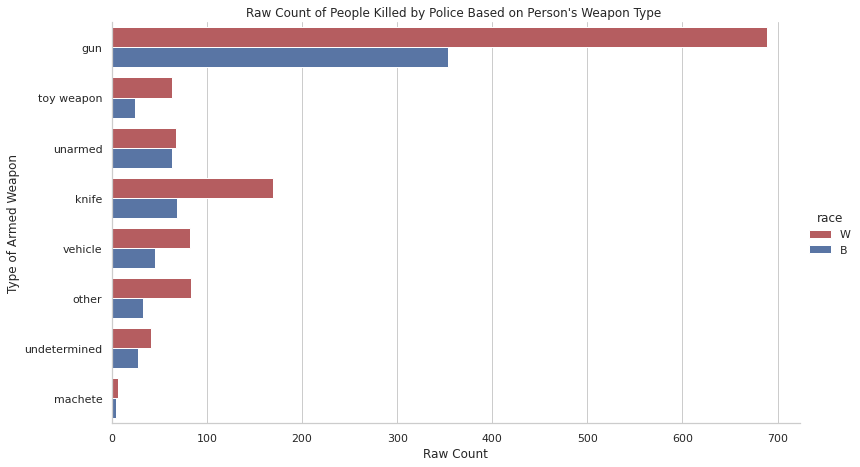

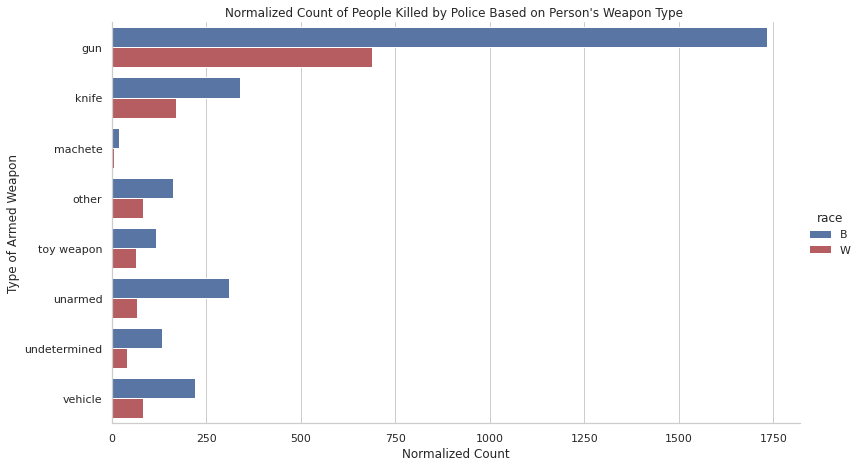

In [ ]:
# Looking at police killings, race and types of weapons
sns.set_theme(style="whitegrid")
BvsW = pol_killings[(pol_killings.race == "B") | (pol_killings.race == "W")]
normalizedVals = BvsW.groupby(['armed','race']).size().reset_index(name="count")

#4.91 is the ratio for white people to black people
normalizedVals["normalizedCount"] = normalizedVals.apply(lambda x: (x["count"] * 4.91 if x["race"] == "B" else x["count"]), axis=1)
g = sns.catplot(
    data=BvsW,
    y="armed", kind="count", hue="race",
    palette={"B" : "b" , "W" : "r"},
    height=6.2, aspect=1.8
)
plt.xlabel("Raw Count")
plt.ylabel("Type of Armed Weapon")
plt.title("Raw Count of People Killed by Police Based on Person's Weapon Type ")
plt.show()
g2 = sns.catplot(
    data=normalizedVals,
    y="armed", x="normalizedCount", kind="bar", hue="race",
    palette={"B" : "b" , "W" : "r"},
    height=6.2, aspect=1.8

)
plt.xlabel("Normalized Count")
plt.ylabel("Type of Armed Weapon")
plt.title("Normalized Count of People Killed by Police Based on Person's Weapon Type ")
plt.show()
#note how unarmed is 5 times for black than white

`This graph is important as it reveals how black people face more killings in proportion to their population make up regardless of arms. To normalize, we used the ratio of black people to white people in the US which is about 4.51.`


`We can also look at a breakdown of gender:`

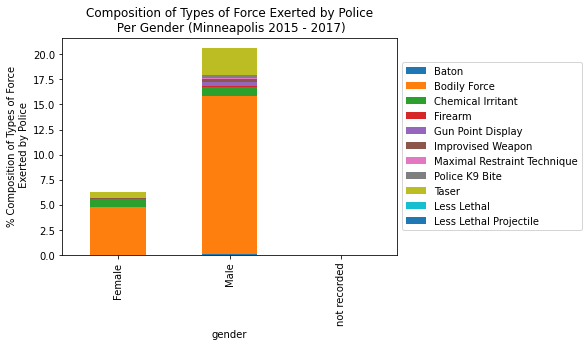

In [ ]:
#Looking at Gender
df[['ForceType','PrimaryOffense','SubjectInjury','ForceTypeAction','EventAge','TypeOfResistance']] = df[['ForceType','PrimaryOffense','SubjectInjury','ForceTypeAction','EventAge','TypeOfResistance']].fillna('N/A',inplace=False) #Negative value to show how many didn't escalate
df['gender'] = df['gender'].fillna('unknown',inplace=False)
popular_gender = df[(df.gender == "Female") | (df.gender == "Male") | (df.gender == "Gender Non-Conforming") | (df.gender == "not recorded")]
GENDER = ((popular_gender.groupby(['gender','ForceType']).count() / Popular_race.groupby(['gender']).count()) * 100)
GENDER[['Gender','force']] = GENDER.index.to_frame() #How to get non applicable forceTypes..?
GENDER = GENDER[(GENDER.force != "N/A")]

df3 = GENDER[['Gender','force', 'responseDate']]
df3vals = GENDER['force'].unique()

g = df3.unstack().plot.bar(stacked=True)
g.legend(df3vals, loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Composition of Types of Force Exerted by Police\n Per Gender (Minneapolis 2015 - 2017)")
plt.ylabel("% Composition of Types of Force\n Exerted by Police")
#todo : sort levels of bar chart
plt.show()

#sns.catplot(x='force', y='responseDate', hue='Gender', data=GENDER,kind='bar',palette=sns.color_palette('tab10',10)) #Change color for better visibility

#plt.xticks(rotation='vertical')
#plt.title('Types of force by Gender')
#plt.show()

`This graph is similar to the last one in that it displays the composition amongst differing genders, we can see that males have higher percentage of gun point display than females.`


`Next, we explore how different age groups are affected:`

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/__init__.py:61: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  plot_obj.generate()


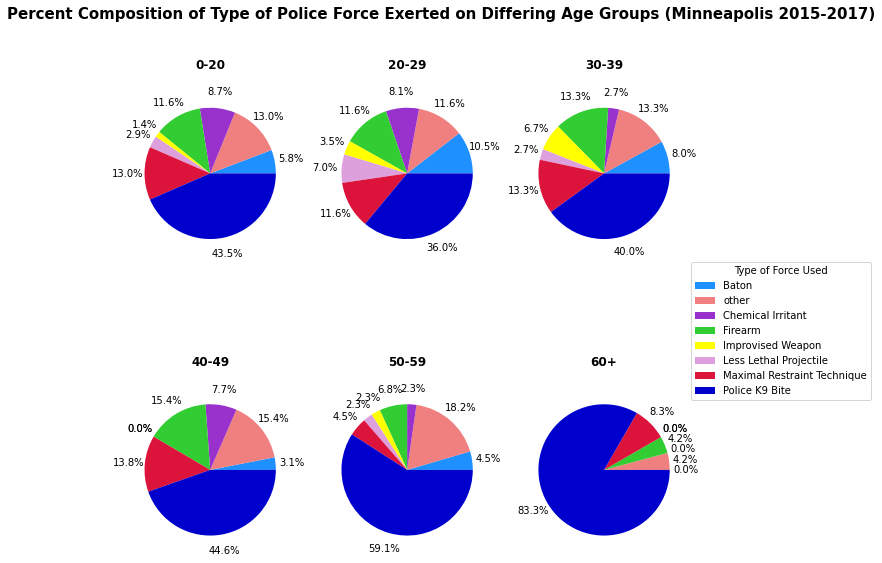

In [ ]:
#Look at EventAge
df[['ForceType','PrimaryOffense','SubjectInjury','ForceTypeAction','EventAge','TypeOfResistance']] = df[['ForceType','PrimaryOffense','SubjectInjury','ForceTypeAction','EventAge','TypeOfResistance']].fillna('N/A',inplace=False) #Negative value to show how many didn't escalate
df = df[(df.EventAge != "N/A")]
bins= [0,20,30,40,50,60, 150]
labels = ["0-20", "20-29", "30-39", "40-49", "50-59", "60+"]

Age = df.groupby(['ForceType','EventAge']).size().reset_index(name='count')  #Group df by ForceType and then by race
Age['agerange'] = pd.cut(Age.EventAge, bins, labels = labels,include_lowest = True)
Age2 =Age.groupby(['ForceType','agerange']).size().reset_index(name='count')
top7forces = Age2['ForceType'].value_counts()[:7].index
Age2.loc[~Age2['ForceType'].isin(top7forces), 'ForceType'] = 'other'

Age2pivoted = Age2.pivot_table(index='ForceType', columns='agerange',
                        values='count', aggfunc='sum', fill_value=0)
labels2 = Age2['ForceType'].unique()
agelabels = Age2['agerange'].unique()

colors = ["crimson", "dodgerblue", "darkorchid", "limegreen", "yellow", "lightcoral", "plum", "mediumblue"]
colordict = {}

fig, ax = plt.subplots(figsize=(10,10))

for i in range(len(labels2)):
  colordict[labels2[i]] = colors[i]
pies = Age2pivoted.plot(kind="pie", use_index = False, labeldistance = None, colors=[colordict[v] for v in Age2['ForceType'].value_counts().keys()]
                       ,subplots=True, layout=(2, 3), autopct="%1.1f%%",  pctdistance=1.25, legend =False, title = agelabels, ax=ax)
pie = pies.flatten()
for x in pie:
  x.set_ylabel('')
  x.title.set_fontsize(12)
  x.title.set_position([0.5, 1.1])
  x.title.set_fontweight("bold")
plt.suptitle("Percent Composition of Type of Police Force Exerted on Differing Age Groups (Minneapolis 2015-2017)", x=0.56, y= 0.94, size = 15, weight = 'bold')
plt.legend(labels2, bbox_to_anchor=(1,1.8), loc="upper left", title="Type of Force Used")
plt.show()

`These pie graphs are interesting for a few reasons: police canine bites are much more common than we expected, especially for the 60+ age group, and firearms and the maximal restraint technique are more common in the middle intervals of the ordered age groups, with their use lessening with more younger and older populations, alike.`

`It may also be interesting to see the different reasons people are stopped, because it may give insight to the racial discrepency we have seen so far in police encounters:`

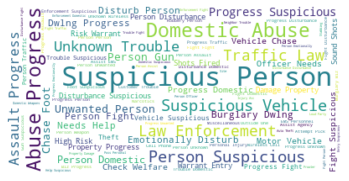

In [ ]:
stopText = " ".join(prob for prob in df.problem if not pd.isnull(prob))

wordcloud = WordCloud(stopwords=stop_words, background_color="white").generate(stopText)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

`It seems that "suspicious person" is the most frequent reason for police stops, this is interesting because much of this data also consists of those who were actually killed by police.`

`We can also analyze the data by looking at how subject injury counts are distributed regionally. To do this, we made a graph of the injuries reported by each Minneapolis precinct:`

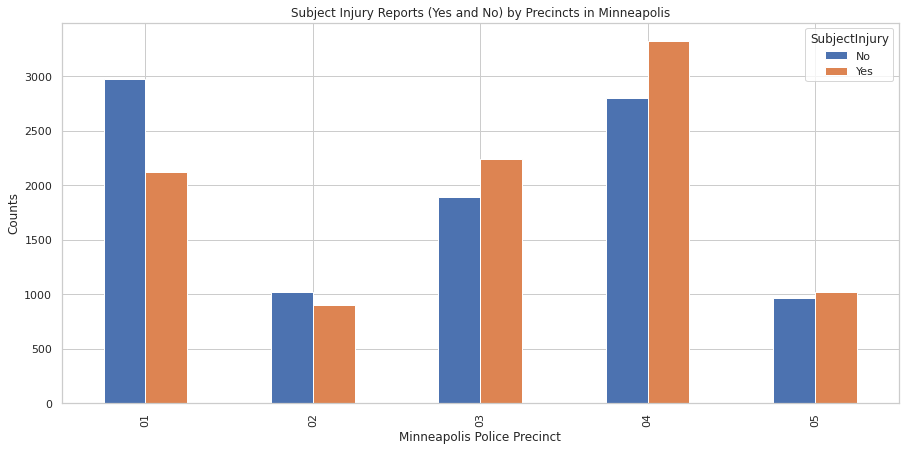

In [ ]:
fig, ax = plt.subplots(figsize=(15,7))
precinct = df.groupby(['policePrecinct', 'SubjectInjury'])
precinct_size = precinct.size()

precinct_size.unstack().plot(kind="bar", ax=ax)
plt.xlabel("Minneapolis Police Precinct")
plt.ylabel("Counts")
plt.title("Subject Injury Reports (Yes and No) by Precincts in Minneapolis")
plt.xlim(0.5, 5.5)
plt.show()

`It seems that Precinct 04 has the highest counts of reported subject injury. A next step may be to analyze what the demographics of the region this precinct covers, are like. Taking things like population size, racial composition of the population and crime rates may be useful to consider.`

# Final Analysis

`Using the insights we have so far, we want to use some techniques to make predictions about the likelihood of certain factors affecting outcomes such as subject injury.`
`We wanted to initially try clustering methods to see if we could accurately tie age and race together for people who were stopped by police, and we do this by creating dummy variables for race, since it is categorical.`

In [ ]:
#create dataframe with race vs. injury to subject

race_age = df[['race']]
dummies = pd.get_dummies(race_age, columns=['race'])
race_age = pd.concat([race_age, dummies], axis=1)
del race_age['race']
race_age['EventAge'] = df['EventAge'].astype(float)

race_age.EventAge = race_age.EventAge.astype(int)

display(race_age)

,race_Asian,race_Black,race_Native American,race_Other / Mixed Race,race_Pacific Islander,race_Unknown,race_White,race_not recorded,EventAge
168323,0,1,0,0,0,0,0,0,29
168324,0,0,0,0,0,0,1,0,18
168325,0,1,0,0,0,0,0,0,50
168326,0,0,0,0,0,0,1,0,41
168327,0,1,0,0,0,0,0,0,16
...,...,...,...,...,...,...,...,...,...
187580,0,0,0,0,0,0,1,0,27
187581,0,1,0,0,0,0,0,0,27
187582,0,1,0,0,0,0,0,0,24
187583,0,0,0,0,0,0,1,0,43


`Next we can create an elbow graph to see what number of clusters would be most ideal for K Means for this data.`

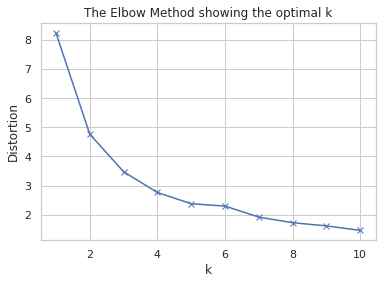

In [ ]:
# kmeans determine k
distortions = []
K = range(1,11) #11 different categories of races -> 11 clusters for K Means
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(race_age)
    kmeanModel.fit(race_age)
    distortions.append(sum(np.min(cdist(race_age, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / race_age.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

`Based on this graph, 2 or 3 clusters seem ideal. So we can now run the algorithm to test if there appears to some correlation between age and race in police stops.`

In [ ]:
#pick 3 clusters based off of elbow method
kmeans = KMeans(n_clusters = 3, random_state = 2)
y_pred = kmeans.fit(race_age)
identified_clusters = kmeans.predict(race_age)
centroids = kmeans.cluster_centers_
print(centroids)

clustered_df = df.copy()
clustered_df['cluster'] = identified_clusters
display(clustered_df.sort_values(by="cluster"))

[[ 1.43786893e-02  6.04964432e-01  6.29635235e-02  3.73845921e-02
  -6.00376953e-18  1.10488875e-02  2.64113819e-01  5.14605721e-03
   3.18808839e+01]
 [ 1.85515145e-02  6.62194738e-01  4.61167592e-02  4.72696782e-02
   2.09621633e-04  1.06907033e-02  2.04485903e-01  1.04810816e-02
   2.09563987e+01]
 [ 5.13808606e-03  5.67116249e-01  6.71162492e-02  3.11496468e-02
   3.79470760e-19  9.63391137e-03  3.12459859e-01  7.38599872e-03
   4.72915864e+01]]


,responseDate,problem,personSearch,vehicleSearch,race,gender,policePrecinct,neighborhood,PrimaryOffense,SubjectInjury,ForceType,ForceTypeAction,EventAge,TypeOfResistance,cluster
168323,2008/01/08 02:07:17+00,Unknown Trouble,NaN,NaN,Black,Male,04,Near - North,DASLT5,No,Bodily Force,Punches,29.0,Tensed,0
178429,2009/02/13 06:50:57+00,Robbery of Biz In Progress,NaN,NaN,Black,Male,03,Minnehaha,ROBBIZ,No,Bodily Force,Slaps,29.0,Verbal Non-Compliance,0
178430,2009/03/04 03:01:18+00,Recover Vehicle,NaN,NaN,Black,Male,04,Jordan,FLEE,No,Improvised Weapon,Flashlight,38.0,Fled in Vehicle,0
178433,2011/12/13 02:17:22+00,Disturbance,NaN,NaN,White,Male,01,Downtown West,DISCON,Yes,Taser,Firing Darts,29.0,Commission of Crime,0
178434,2011/12/20 03:47:23+00,Domestic Abuse-In Progress,NaN,NaN,Black,Male,04,Jordan,DASLT2,Yes,Bodily Force,Push Away,38.0,Fled on Foot,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170636,2009/02/10 19:21:52+00,Suspicious Person,NaN,NaN,White,Male,01,Downtown West,HLTWEL,Yes,Taser,Firing Darts,43.0,Commission of Crime,2
175236,2011/04/26 01:57:27+00,Audible Business Alarm,NaN,NaN,Black,Male,04,Willard - Hay,BURGB,Yes,Bodily Force,Kicks,47.0,Verbal Non-Compliance,2
178765,2014/10/08 17:32:11+00,Suspicious Person,NaN,NaN,Black,Male,03,Wenonah,OBSTRU,Yes,Bodily Force,Body Weight to Pin,44.0,Commission of Crime,2
176743,2012/08/11 17:19:29+00,Emotionally Disturb Person,NaN,NaN,White,Male,01,North Loop,CIC,No,Taser,Firing Darts,42.0,Verbal Non-Compliance,2


In [ ]:
clustered_df.groupby(['cluster', 'race']).size()

cluster  race              
0        Asian                   95
         Black                 3997
         Native American        416
         Other / Mixed Race     247
         Unknown                 73
         White                 1745
         not recorded            34
1        Asian                  177
         Black                 6318
         Native American        440
         Other / Mixed Race     451
         Pacific Islander         2
         Unknown                102
         White                 1951
         not recorded           100
2        Asian                   16
         Black                 1766
         Native American        209
         Other / Mixed Race      97
         Unknown                 30
         White                  973
         not recorded            23
dtype: int64

In [ ]:
clustered_df.groupby(['cluster', 'EventAge']).count()

responseDate  problem  ...  ForceTypeAction  TypeOfResistance
cluster EventAge                         ...                                   
0       27.0               797      797  ...              797               797
        28.0               785      785  ...              785               785
        29.0               675      675  ...              675               675
        30.0               575      575  ...              575               575
        31.0               575      575  ...              575               575
...                        ...      ...  ...              ...               ...
2       71.0                 1        1  ...                1                 1
        72.0                 2        2  ...                2                 2
        73.0                 4        4  ...                4                 4
        74.0                 5        5  ...                5                 5
        82.0                 4        4  ...                4                 4

[66 rows x 13 columns]

`Based on these results, it seems that there is not any clear distinction between age and race, at least with 3 clusters, this is likely due to the fact that KMeans is more suitable for numeric or ordinal data, rather than categorical. Additionally, one reason may also be that there is no real association of race and age, collectively, in predicting what individuals are stopped by police. Although this did not go as expected, we can see that younger populations of all races have a much higher count of being stopped. Our dataset only really had "EventAge" that was numeric, and the clusters seemed to use the age data and sort it into chronological intervals. It may also be useful to add more quantitative data if we want to use clustering methods more effectively in the future. We included these results in the report not because of the conclusions drawn, but because it helped us confirm that we need more data to be able to make conclusions, rather than just by relying on our assumptions about factors that may produce strong correlations. This, and our inconclusive linear regression (not featured), were important to help us explore methods more suitable for categorical data.`

`We decided to also make a decision tree based on the features: problem(why the police were called), the type of resistance, race, gender, and age. Our decision nodes would be whether the subject has sustained an injury from the enocounter or not. This allows us to possibly see a correlation between what factors sustain more injuries.`


Index(['responseDate', 'problem', 'PrimaryOffense', 'SubjectInjury',
       'ForceType', 'ForceTypeAction', 'race', 'gender', 'EventAge',
       'TypeOfResistance', 'policePrecinct', 'neighborhood'],
      dtype='object')


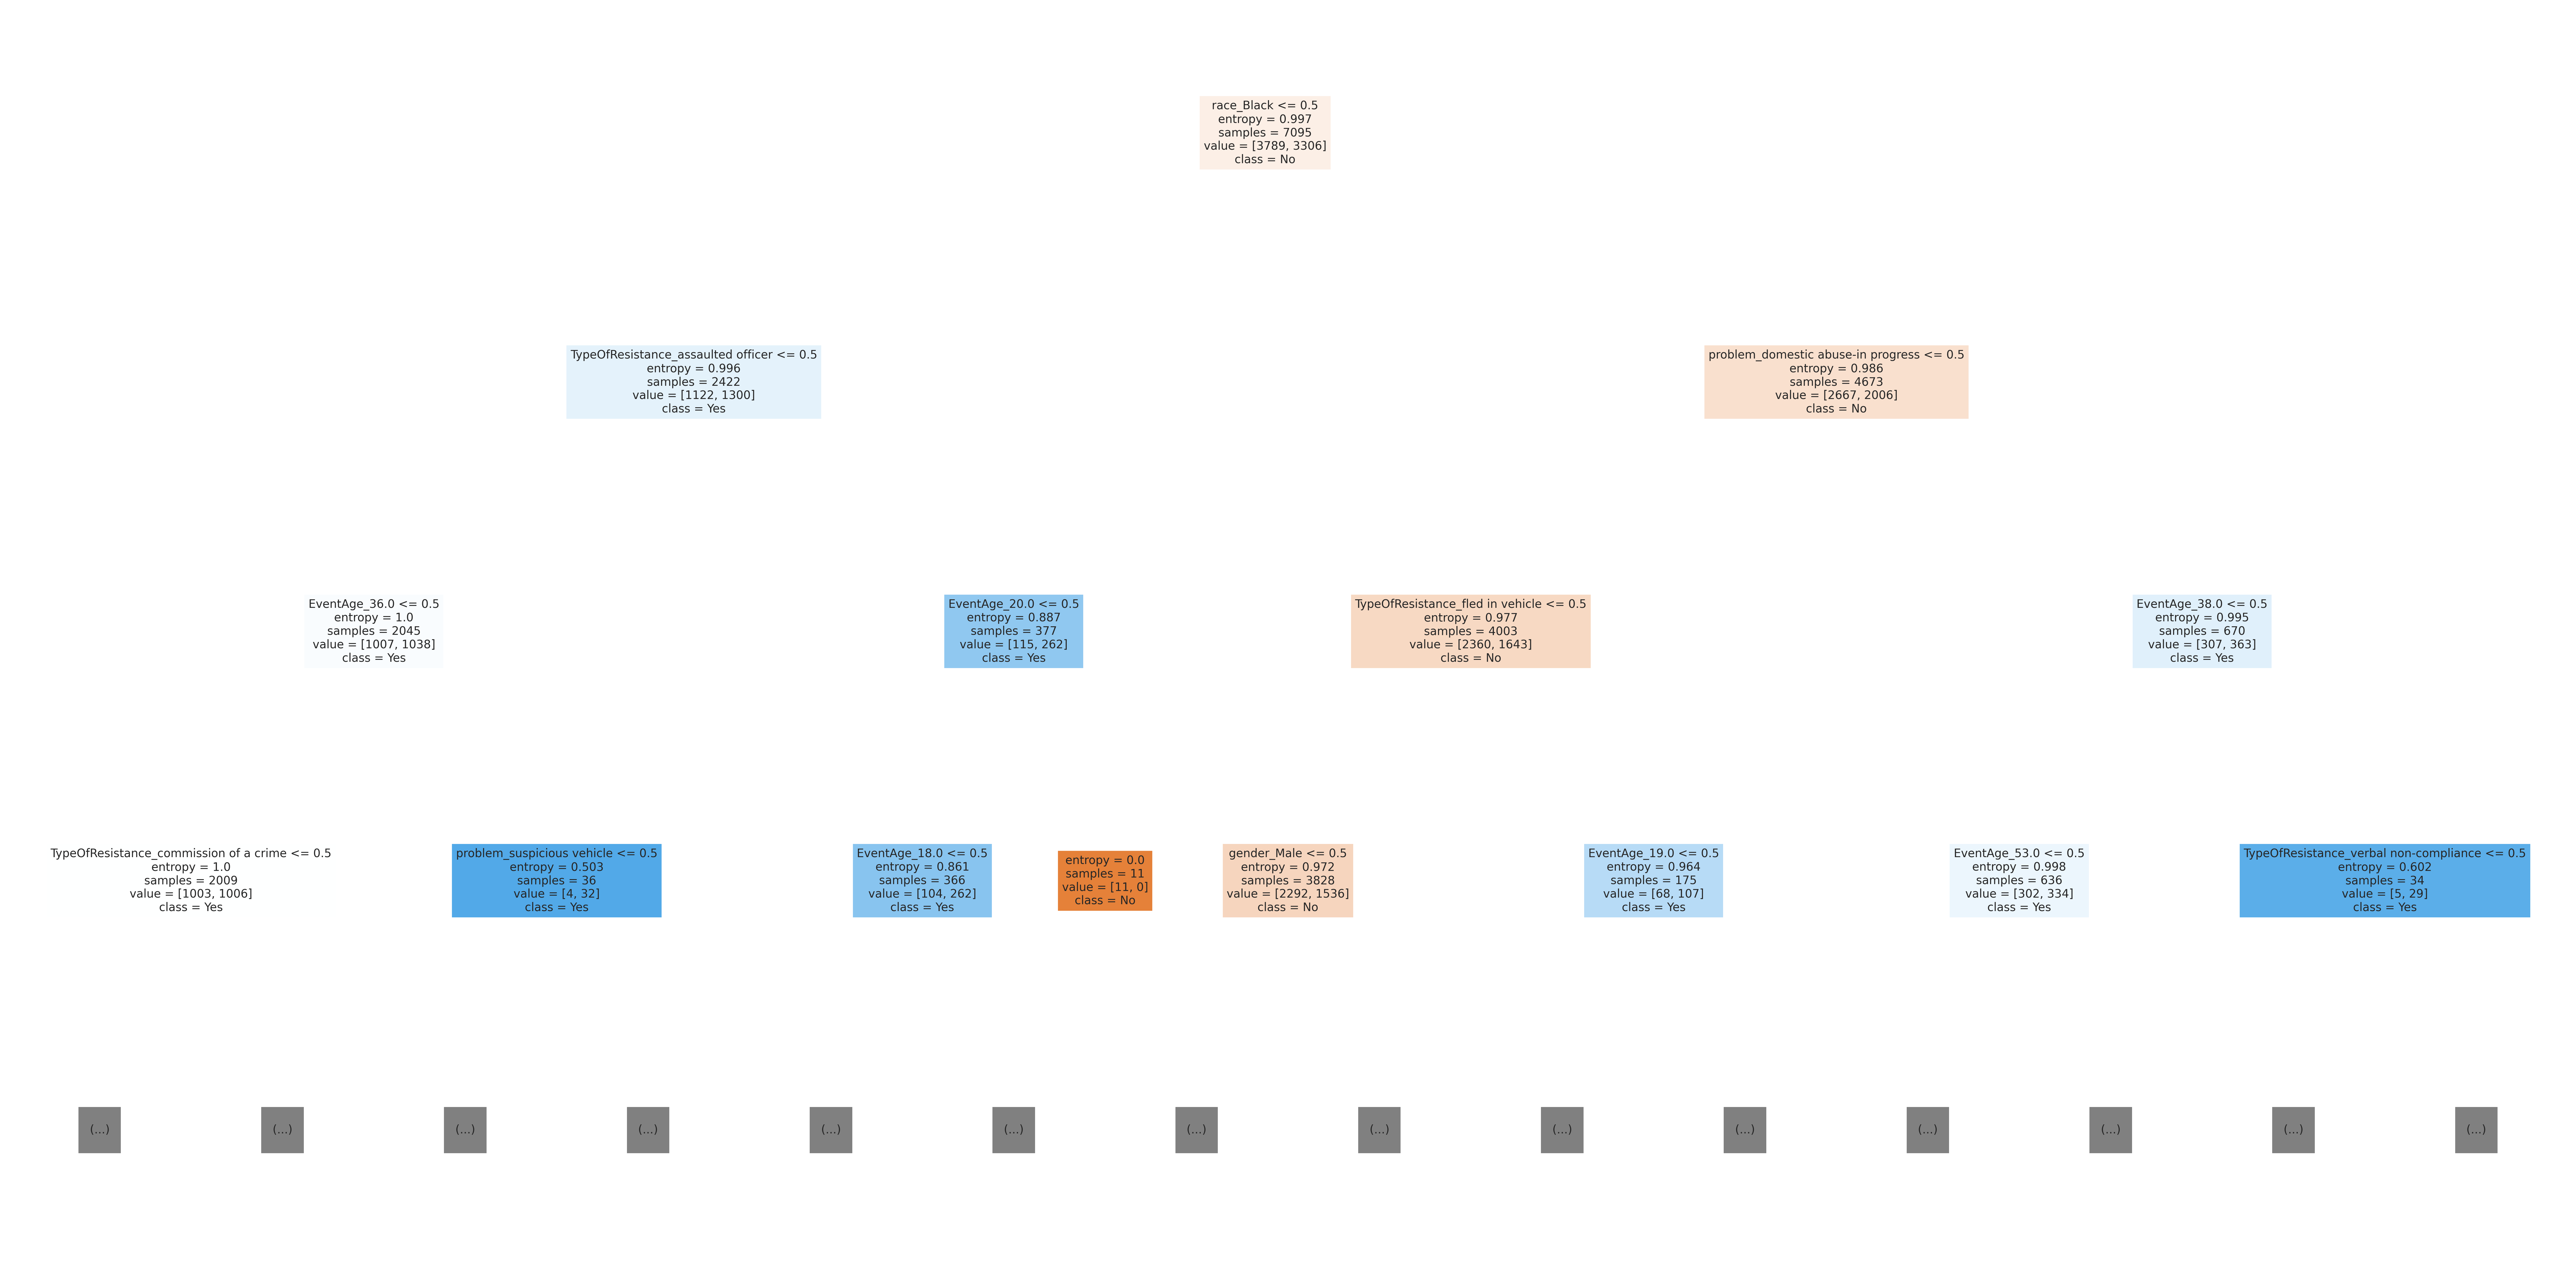

Accuracy:  0.772189349112426


In [ ]:
print(pol_force.columns)
Xdata = pol_force[['problem', 'TypeOfResistance', 'race', 'gender', 'EventAge', 'SubjectInjury']]
Xdata = Xdata.dropna()

Xdata['TypeOfResistance'] = Xdata['TypeOfResistance'].str.strip()
Xdata['TypeOfResistance'] = Xdata['TypeOfResistance'].str.lower()
Xdata['problem'] = Xdata['problem'].str.strip()
Xdata['problem'] = Xdata['problem'].str.lower()
# Xdata['PrimaryOffense'] = Xdata['PrimaryOffense'].str.strip()


# problems =Xdata.groupby(['problem']).size().reset_index(name="count")
top7P = Xdata['problem'].value_counts()[:7].index.tolist()

Xdata = Xdata.loc[(Xdata['problem'].isin(top7P))]


X = Xdata[['problem', 'TypeOfResistance', 'race', 'gender', 'EventAge']]
y = Xdata[['SubjectInjury']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
ohe = OneHotEncoder(handle_unknown = 'ignore')

ohe.fit(X_train)
X_train_ohe = ohe.transform(X_train).toarray()

# Creating this DataFrame is not necessary its only to show the result of the ohe
ohe_df = pd.DataFrame(X_train_ohe, columns=ohe.get_feature_names(X_train.columns))

ohe_df.head()
clf = DecisionTreeClassifier(criterion='entropy')

clf.fit(X_train_ohe, y_train)
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (40,20), dpi=300)
tree.plot_tree(clf,
               feature_names = ohe_df.columns, 
               class_names=np.unique(y).astype('str'),
               filled = True,  max_depth=3, fontsize=10)
plt.show()
X_test_ohe = ohe.transform(X_test).toarray()
y_preds = clf.predict(X_test_ohe)

print('Accuracy: ', accuracy_score(y_test, y_preds))

`As you can see our decision tree has an accuracy of about 77%. The displayed portion is limited to a depth of three however, we can see that the starting node is dependent on the person being black. Since we used one-hot encoder and the node indicates the value should be less than < 0.5 in order to be considered no, this shows that having a 1 in the black column of the data (indicating the person is black) causes the tree to lean towards yes for the final leaf node of subject injury.`

`As a final note, we have made some interesting discoveries throughout this project and we hope to be able to contribute to the effort of making police encounters safer. The first step to do so would be to get all the data and research the specific areas that need to be addressed, and then it is important for experts to prepare an effective action plan based on this information. We hope to add to these insights in the future with more population data and take into account regional distributions of race and age groups, to get a clearer picture.`